In [1]:
import requests
import json
import prettytable
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
data_path = r"C:\Users\nsbea\OneDrive\4_coding\price\data"
os.chdir(data_path)

# 1. Read dataset

In [3]:
# define parameters
target = ['WPUID51',
          'WPUID52',
          'WPUID53',
          'WPUID54',
          'WPUFD4',
          ]

map_stage = {'WPUID51':'Stage 1',
             'WPUID52':'Stage 2',
             'WPUID53':'Stage 3',
             'WPUID54':'Stage 4',
             'WPUFD4':'Final demand (including exports)',
             'WPUFD42':'service_final',
             'WPUID63':'service_intermediate'
             }

start = '2015'
end = '2022'

In [4]:
# ref https://www.bls.gov/developers/api_python.htm#python2
def get_data_us(target,start,end):
    headers = {'Content-type': 'application/json'}
    data = json.dumps({"seriesid":target,"startyear":start, "endyear":end})
    p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
    
    json_data = json.loads(p.text)
    for series in json_data['Results']['series']:
        x=prettytable.PrettyTable(["series id","year","period","value","footnotes"])
        seriesId = series['seriesID']
        for item in series['data']:
            year = item['year']
            period = item['period']
            value = item['value']
            footnotes=""
            for footnote in item['footnotes']:
                if footnote:
                    footnotes = footnotes + footnote['text'] + ','
            if 'M01' <= period <= 'M12':
                x.add_row([seriesId,year,period,value,footnotes[0:-1]])
        output = open(seriesId + '.csv','w')
        output.write (x.get_string().replace('|',','))
        output.close()

In [5]:
def read_df(target):
    output = []
    # get dataframe from each csv
    target_csv = [x + '.csv' for x in target]
    
    for f in target_csv:
        df = pd.read_csv(f, header=1, skipfooter=1, engine='python')
        # remove whitespace
        df.columns = df.columns.str.strip()
        df['series id'] = df['series id'].str.strip()
        # rename the ID
        df.rename(columns = {'series id':'stage'}, inplace = True)
        df = df.drop(df.index[0])
        # change type of each columns
        df['year'] = df['year'].astype(int)
        df['period'] = df['period'].str.strip().str[1:].astype(int)
        df['date'] = pd.to_datetime(['{}-{}-01'.format(y,m) for y, m in zip(df.year, df.period)])
        df = df[['date','stage','value']]
        df['country'] = 'US'
        df['stage'] = df['stage'].map(map_stage)
        output.append(df) 
    return output

In [6]:
def get_data_jp(im=True, ex=True, service=False):
    # japanese data
    url = r'https://www.boj.or.jp/statistics/pi/fdid/fdid.xlsx'
    
    df = pd.read_excel(url)
    
    col = list(df.columns)
    # delete columns which not be used, and rename
    del col[0:2]
    del col[1]
    df = df[col]
    df.rename(columns = {'Unnamed: 2':'stage', 'Unnamed: 4':'name'}, inplace = True)
    
    if service == True:
        df_jp = df[df['name']=='Services'].set_index('stage').drop('name',axis=1).T
    else:
        if im == True:
            df_jp = df[df['name']=='All commodities'].set_index('stage').drop('name',axis=1).T
        else:
            df_jp = df[df['name'] == 'All commodities, less imports'].set_index('stage').drop('name',axis=1).T
        
    idx = [str(x) for x in list(df_jp.index)]
    year, month = [x[0:4] for x in idx], [x[4:] for x in idx]
    df_jp['year'], df_jp['month'] = year, month
    df_jp['date'] = pd.to_datetime(['{}-{}-01'.format(y,m) for y, m in zip(df_jp.year, df_jp.month)])
    df_jp = df_jp.drop(['year','month'],axis=1)
    df_jp = pd.melt(df_jp, id_vars='date',value_vars=['Stage 1','Stage 2','Stage 3','Stage 4','Final demand (excluding exports)','Final demand (including exports)'])
    
    if ex == True:
        df_jp = df_jp[df_jp['stage'] != 'Final demand (excluding exports)']
    
    df_jp['country'] = 'JP'
    return df_jp

In [7]:
# work flow
get_data_us(target,start,end)
df_list = read_df(target)
df_us = pd.concat(df_list).reset_index(drop=True)
df_jp = get_data_jp(im=True)

# conbine the dataframe
df = pd.concat([df_us,df_jp]).reset_index(drop=True)

# 2. Plot the index

In [8]:
def plot_twoline(df_us, df_jp, zero=False):
    
    sns.set_style('whitegrid')
    sns.set_palette("viridis", desat=0.9)
    
    # set font size
    # ref: https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
    SMALL_SIZE = 15
    MEDIUM_SIZE = 18
    BIGGER_SIZE = 26

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    # plot the figure
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20,8))
    
    sns.lineplot(data=df_us, x='date',y='value', hue='stage', markers=True,ax=ax1).set(title='USA')
    sns.lineplot(data=df_jp, x='date',y='value', hue='stage', markers=True,ax=ax2).set(title='JAPAN')
    
    if zero == True:
        ax1.axhline(0, c='black', linewidth=0.7)
        ax2.axhline(0, c='black', linewidth=0.7)
    
    plt.show()

## 2-1. Include import price

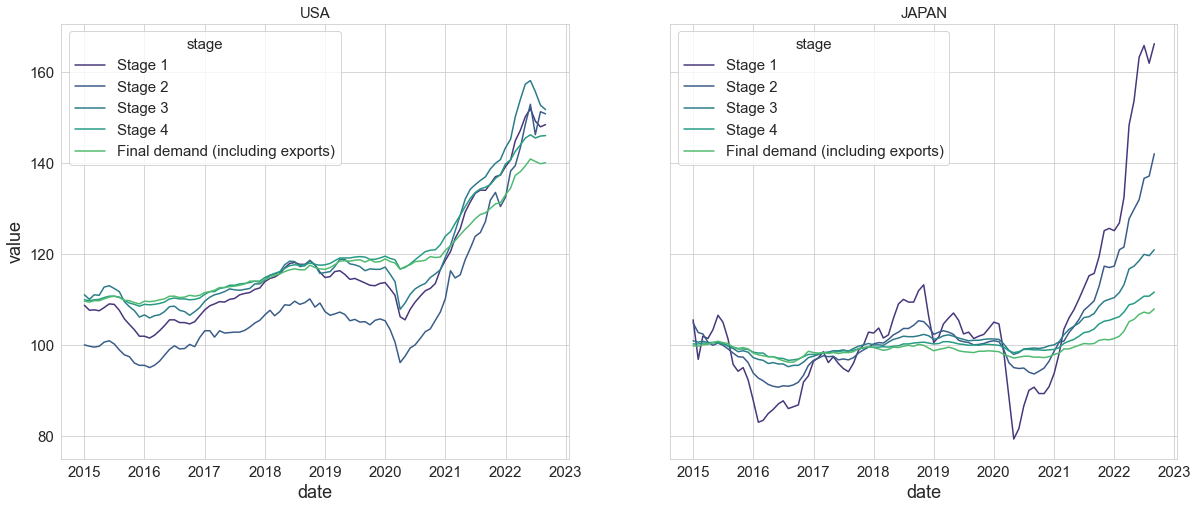

In [9]:
plot_twoline(df_us, df_jp)

## 2-2. Exclude import price

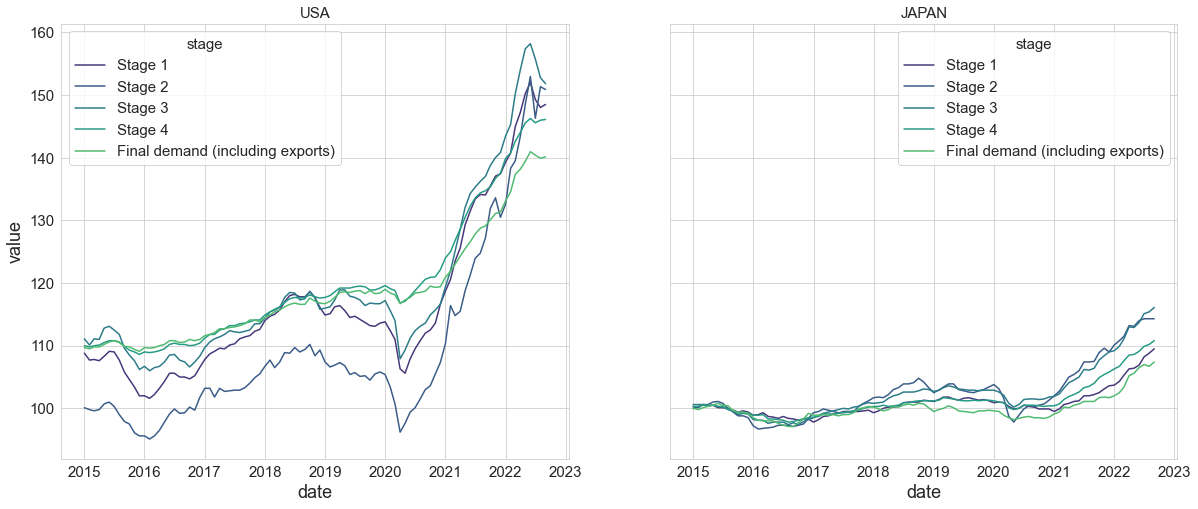

In [24]:
df_jp = get_data_jp(im=False)
plot_twoline(df_us, df_jp)

NOTE: US index is not 2015 = 100

# 3.  YoY/MoM change

## 3-1. define dataflames

At this point, we have long format dataframes(**df_us** and **df_jp**). It might be efficient that we calculate year on year change just after getting data from the API, but in this case, the function to acquire data becomes complicated. I prefer simple fucntion, thus define new function, which use long dataframe as argument, and transform the data like "long -> wide -> calculate YoY/ MoM -> long".

In [10]:
# check the dataflame format
df_jp.head()

,date,stage,value,country
0,2015-01-01,Stage 1,105.6,JP
1,2015-02-01,Stage 1,96.9,JP
2,2015-03-01,Stage 1,102.0,JP
3,2015-04-01,Stage 1,101.5,JP
4,2015-05-01,Stage 1,103.4,JP


In [11]:
def get_diff(df_wide,period=1):
    # get difference from wide format dataframe
    df_diff = df_wide.pct_change(periods=period).apply(lambda x: x*100).dropna().reset_index()
    return df_diff

def get_long(df,service=False):
    # get long from wide format dataflame
    if service == False:
        df_long = pd.melt(df, id_vars='date',value_vars=['Stage 1','Stage 2','Stage 3','Stage 4','Final demand (including exports)'])
    else:
        df_long = pd.melt(df, id_vars='date',value_vars=['service_intermediate','service_final'])
    return df_long

# NOTE: long df is easier to create multi line plot with seaborn

In [12]:
def diff_calc(df,service=False):
    # calculate yoy and mom change from long df
    df_wide = pd.pivot(df, index='date', columns='stage', values='value')
    # 前月比
    df_mom = get_diff(df_wide, period=1)
    df_mom = get_long(df_mom,service)
    # 前年比
    df_yoy = get_diff(df_wide, period=12)
    df_yoy = get_long(df_yoy,service)
    
    return df_mom, df_yoy

In [13]:
# calc diff for each country
df_us_mom, df_us_yoy = diff_calc(df_us)
df_jp_mom, df_jp_yoy = diff_calc(df_jp)

## 3-2. Plot  YoY change include import price

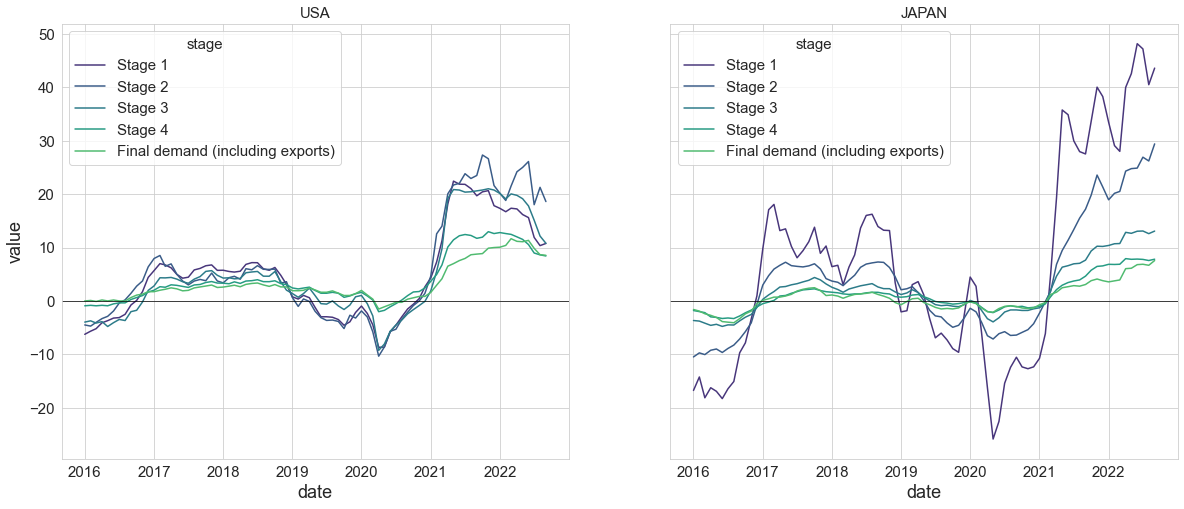

In [14]:
plot_twoline(df_us_yoy, df_jp_yoy, zero=True)

NOTE: Price index for JAPAN includes import goods.

## 3-3. Plot  YoY change exclude import price

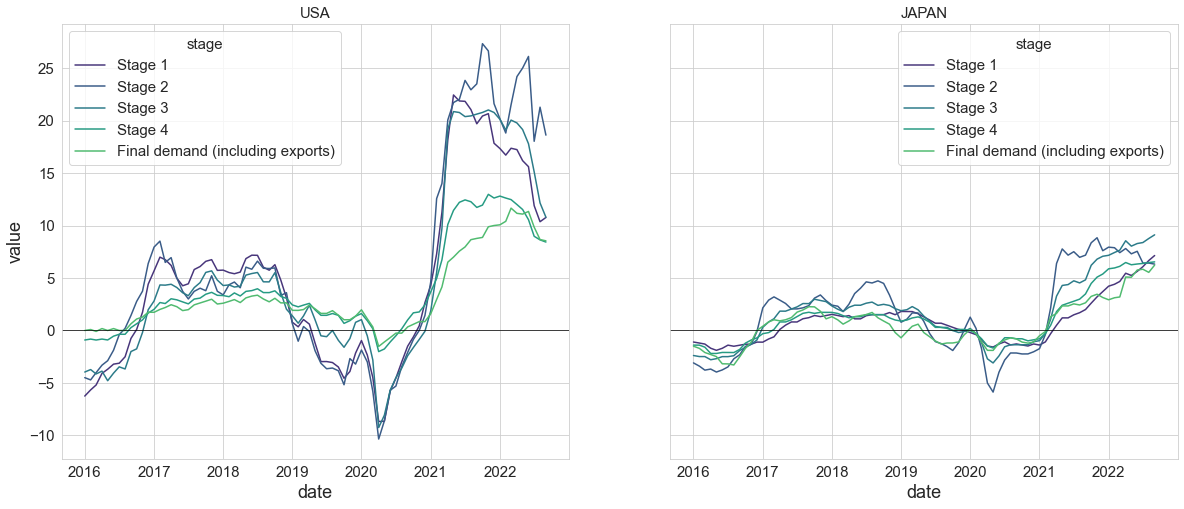

In [15]:
df_jp = get_data_jp(im=False)
df_jp_mom, df_jp_yoy = diff_calc(df_jp)
plot_twoline(df_us_yoy, df_jp_yoy, zero=True)

Insight:
    Almost all part of the price change in Japan is driven from import price. If the effect from import goods is eliminated, the price change is relatively smaller than U.S. across all intermediate stages. 

# 4. Distribution of price change

Now, I will compare the price change in each stage. The 45 degree lines mean the perfect pass through.

In [16]:
# ref https://stackoverflow.com/questions/48122019/how-can-i-plot-identity-lines-on-a-seaborn-pairplot
def plot_unity(xdata, ydata, **kwargs):
    mn = min(xdata.min(), ydata.min())
    mx = max(xdata.max(), ydata.max())
    points = np.linspace(mn-3, mx+3, 100)
    plt.gca().plot(points, points, color='k', marker=None,
            linestyle='--', linewidth=1.0)

In [17]:
def plot_pairplot(df):
    df_wide = pd.pivot(df, index='date', columns='stage', values='value')
    df_wide= df_wide[['Stage 1','Stage 2','Stage 3','Stage 4','Final demand (including exports)']]
    df_wide.rename(columns = {'Final demand (including exports)':'FD'}, inplace = True)
    df_wide['inflation_in_FD'] = df_wide['FD'] >= 0 
    
    grid = sns.pairplot(df_wide, hue='inflation_in_FD', kind='scatter',palette="pastel")
    grid.map_offdiag(plot_unity)

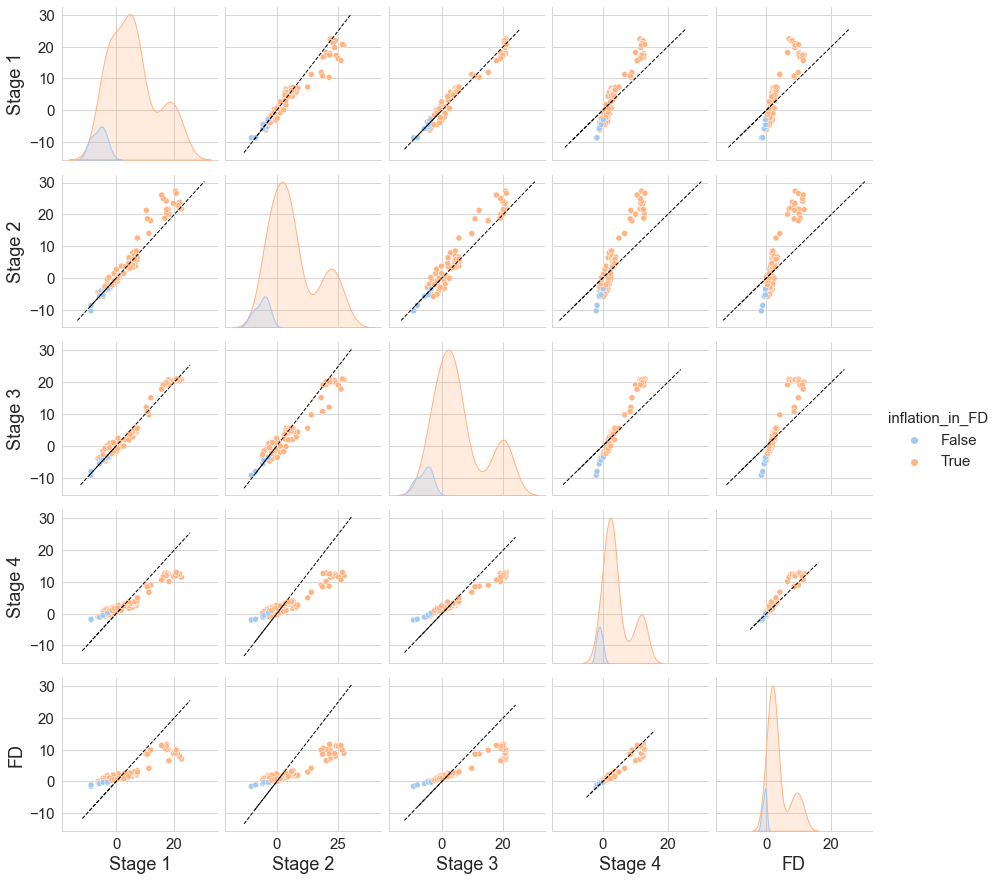

In [18]:
# US
plot_pairplot(df_us_yoy)

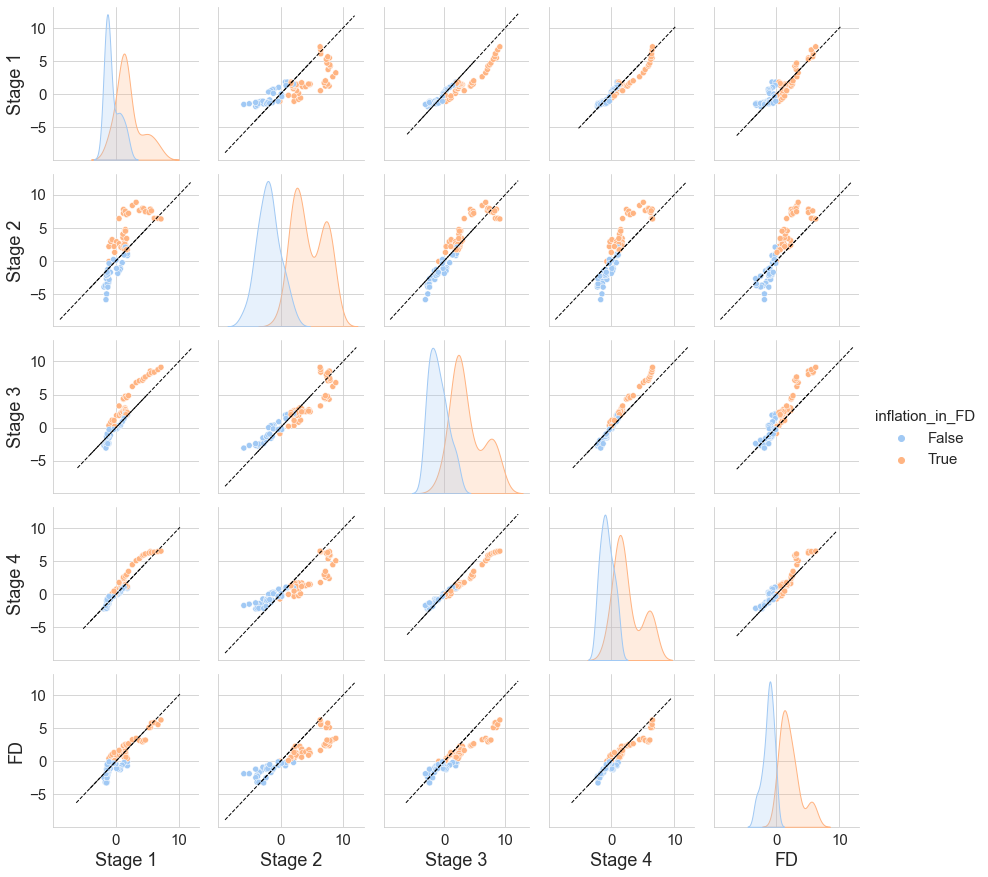

In [19]:
# JAPAN
plot_pairplot(df_jp_yoy)

# 5. Service price

The trend of service price is one of the most important factor to determine overall price change. Thus, in this section, I will analyze price fractuation.

In [20]:
target_service = ['WPUFD42',
                 'WPUID63']

get_data_us(target_service,start,end)
df_list = read_df(target_service)

df_us_service = pd.concat(df_list).reset_index(drop=True)
df_jp_service = get_data_jp(service=True)

In [21]:
# calc diff for each country
df_us_ser_mom, df_us_ser_yoy = diff_calc(df_us_service, service=True)
df_jp_ser_mom, df_jp_ser_yoy = diff_calc(df_jp_service)

## 5-1. Index

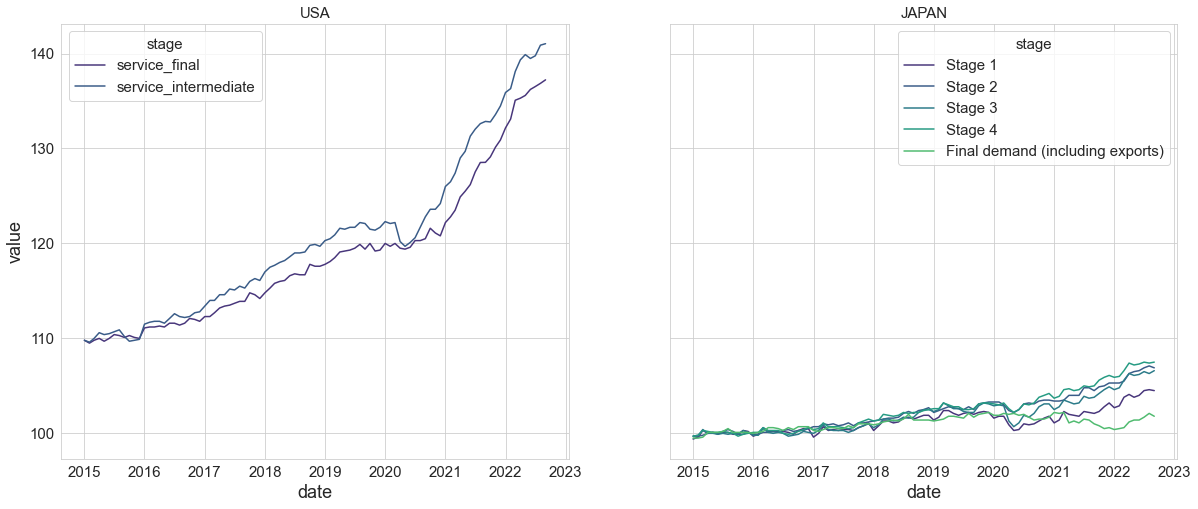

In [22]:
# the level of service price
plot_twoline(df_us_service, df_jp_service)

## 5-2. YoY change

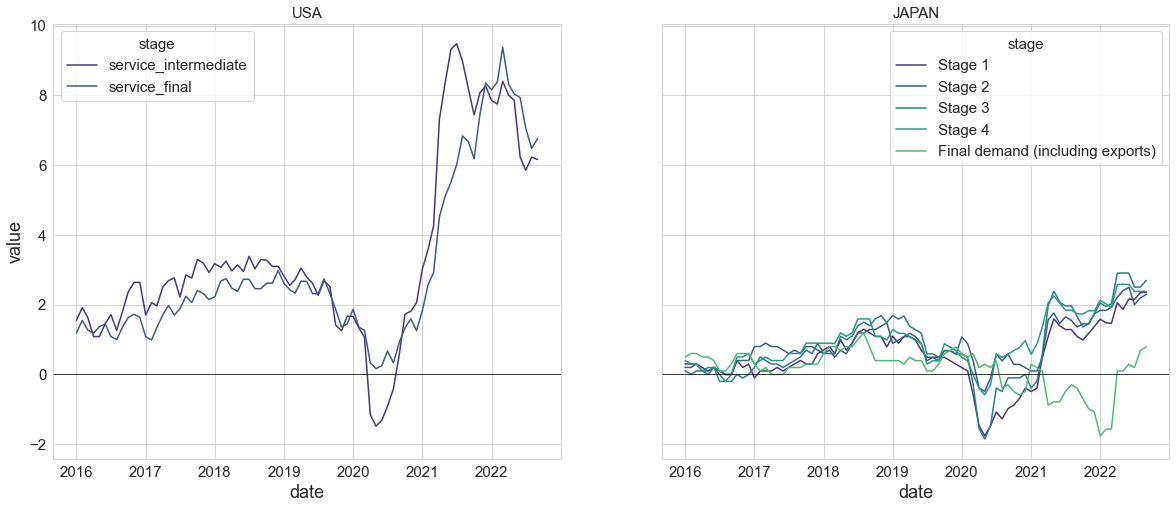

In [23]:
# yoy change
plot_twoline(df_us_ser_yoy, df_jp_ser_yoy, zero=True)

# 6. Sentiment Analysis from News paper articles dataset

Under construction

Use kaggle newspaper articles dataset